<a href="https://colab.research.google.com/github/chris051091/Tesis_Maestria/blob/main/climatologia/src/vizcaina/Climatologia_Temperatura_Vizcaina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_CLIMATOLOGIA = '/climatologia/figures/'
NOMBRE_ESTACION = 'vizcaina'

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
PATH_FINAL_FIGURAS_CLIMATOLOGIA = PATH_DRIVE + PATH_CLIMATOLOGIA + NOMBRE_ESTACION + '/temperatura/'

FILE_DATOS_TRATADOS = NOMBRE_ESTACION.lower() + '_tratados_temp.csv'


In [3]:
VARIABLE = 'TEMP'
VARIABLE_STR = 'Temperatura'
NOMBRE_EJE_Y = 'Temperatura (°C)'

In [4]:
#Read the data

df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + FILE_DATOS_TRATADOS,
                 sep = ';',
                #  parse_dates = ["FECHA"],
                #  date_parser = lambda col: pd.to_datetime(col)
                )

In [5]:
df['MES'] = df['FECHA'].apply(lambda x: x[5:7])
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

In [6]:
#Start every matrix

##Iniciate the month in every season
xnr = ['12', '01', '02', '06', '07', '08']
xr = ['03', '04', '05', '09', '10', '11']

##y is to make the hourly calculation
y = np.arange(0,24)

##Merge the dataframe, so that it will be only one for every season
nrain = df[df['MES'].str.contains('|'.join(xnr))] # DF con los datos de meses sin lluvia
rain = df[df['MES'].str.contains('|'.join(xr))]   # DF con los datos de meses con lluvia

## Use all the dataframe (No split)
total = df.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
total['mean'] = total[(VARIABLE, 'mean')]
total['std'] = total[(VARIABLE, 'std')]
total = total[['HORA', 'mean', 'std']]

#Fill the matrix of the no raining season
nrdf = nrain.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
nrdf['mean'] = nrdf[(VARIABLE, 'mean')]
nrdf['std'] = nrdf[(VARIABLE, 'std')]
nrain = nrdf[['HORA', 'mean', 'std']]


#Do the same for the the raining season
rdf = rain.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
rdf['mean'] = rdf[(VARIABLE, 'mean')]
rdf['std'] = rdf[(VARIABLE, 'std')]
rain = rdf[['HORA', 'mean', 'std']]


<ipython-input-7-971ac4629e29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HORA'] = df['HORA'].astype(int)


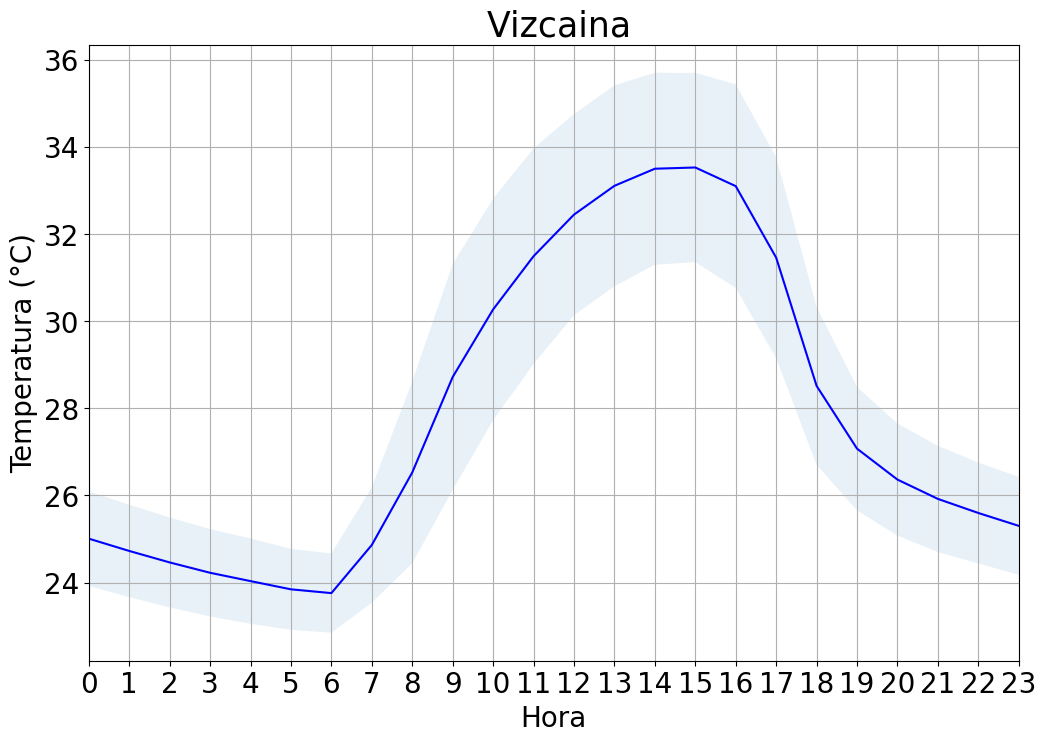

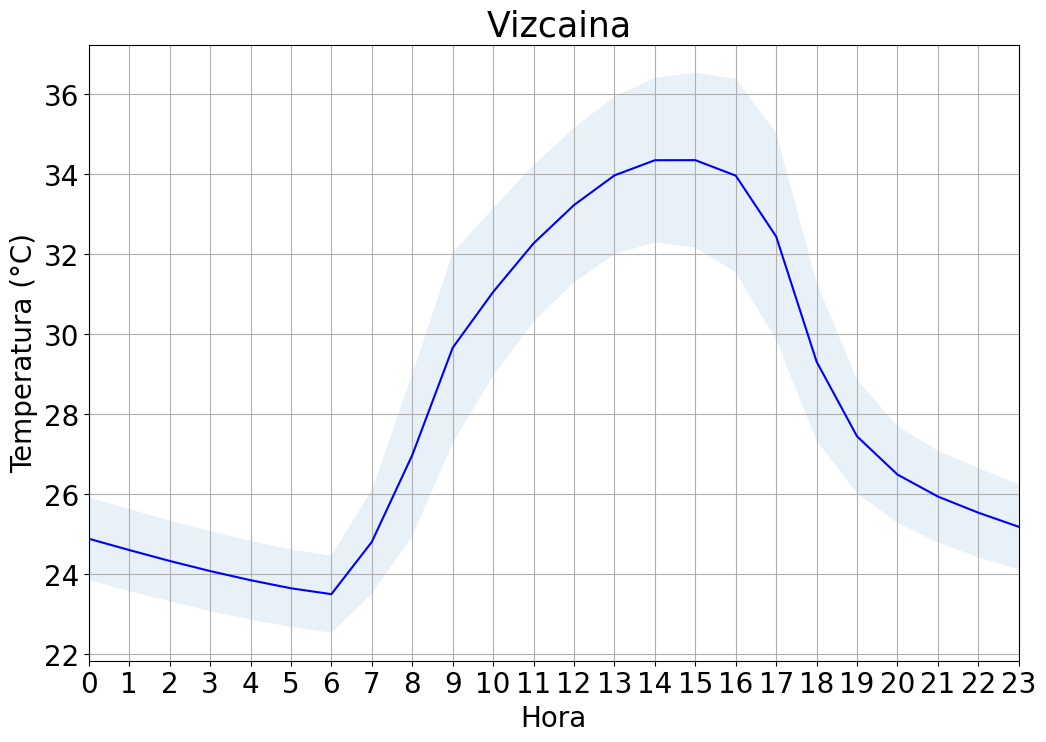

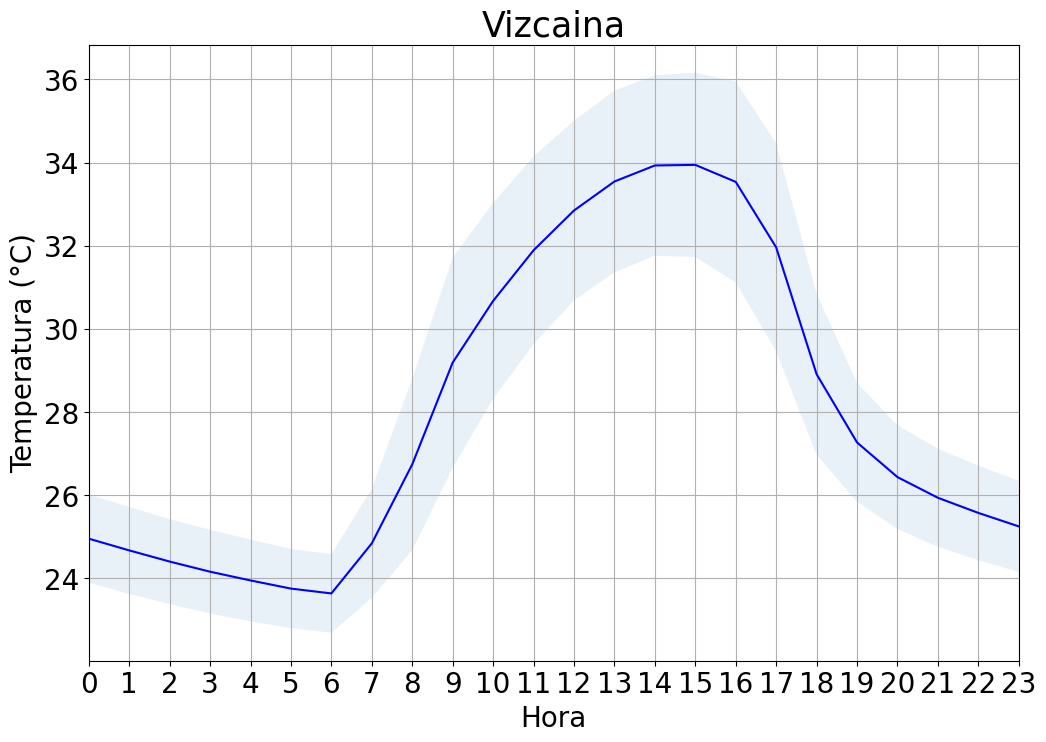

In [7]:
#I made a plot in a very automatic way, you need to improve it, I think a plot matrix es better, but you need to check
def plot_per_hour(df, titulo, name_to_save):
  plt.figure(figsize = (12,8))

  df['HORA'] = df['HORA'].astype(int)

  plt.xticks(df['HORA'], fontsize= 20)
  plt.yticks(fontsize= 20)
  plt.plot(df['mean'], color = 'b')
  plt.fill_between(df['HORA'], df['mean'] + df['std'], df['mean'] - df['std'], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.grid()
  plt.xlim([0, 23])
  plt.xlabel("Hora", fontsize= 20)
  plt.ylabel(NOMBRE_EJE_Y, fontsize= 20)
  plt.title(titulo, fontsize= 25)

  plt.savefig(PATH_FINAL_FIGURAS_CLIMATOLOGIA + f'{name_to_save}', format='png', bbox_inches = 'tight' )


plot_per_hour(rain, f' {NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_lluvia.png')
plot_per_hour(nrain, f' {NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_no_lluvia.png')
plot_per_hour(total, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_todos_meses.png')

In [8]:
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.cbook import _reshape_2D

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

def plot_caja_bigote(
    df, ## Dataframe usado para calcular las metricas de cuartiles
    columna_x, ## Nombre de la columna para agrupar
    columna_y, ## Nombre de la columna con la variable
    titulo, ## Titulo de la figura
    rotulo_x, ## Nombre que aparece en el rotulo para el eje X
    rotulo_y, ## Nombre que aparece en el rotulo para el eje Y
    nombre_estacion, ## Nombre de la estación
    nombre_figura, ## Nombre usado para guardar la figura
    path_para_salvar, ## Path para salvar la figura
    lista_xtick=[] ## Colocar para substituir los nombres en el eje X
    ):

  stats = {}

  # Compute the boxplot stats (as in the default matplotlib implementation)
  variable_label = df[columna_x].unique()
  variable_label = np.sort(variable_label)
  for var_filter in variable_label:

    df_plot = df[df[columna_x] == var_filter][columna_y].to_numpy()
    stats[var_filter] = my_boxplot_stats(df_plot, percents=[25, 75])[0]

  fig, ax = plt.subplots(1, 1)
  fig.set_size_inches(12,8)
  ax.bxp([stats[numb] for numb in stats.keys()], positions=range(len(variable_label)))
  ax.grid()
  ax.set_xlabel(rotulo_x, fontsize=20)
  ax.set_ylabel(rotulo_y, fontsize=20)
  ax.xaxis.set_tick_params(labelsize=20)
  ax.yaxis.set_tick_params(labelsize=20)
  ax.set_title(nombre_estacion.capitalize(), fontsize= 20)
  plt.ylim([15,45])
  if lista_xtick:
    ax.set_xticks(range(0, len(lista_xtick), 1), labels = lista_xtick, fontsize= 20)
    fig.savefig(path_para_salvar + nombre_estacion.capitalize() + "_" + nombre_figura, format='png', bbox_inches = 'tight' )

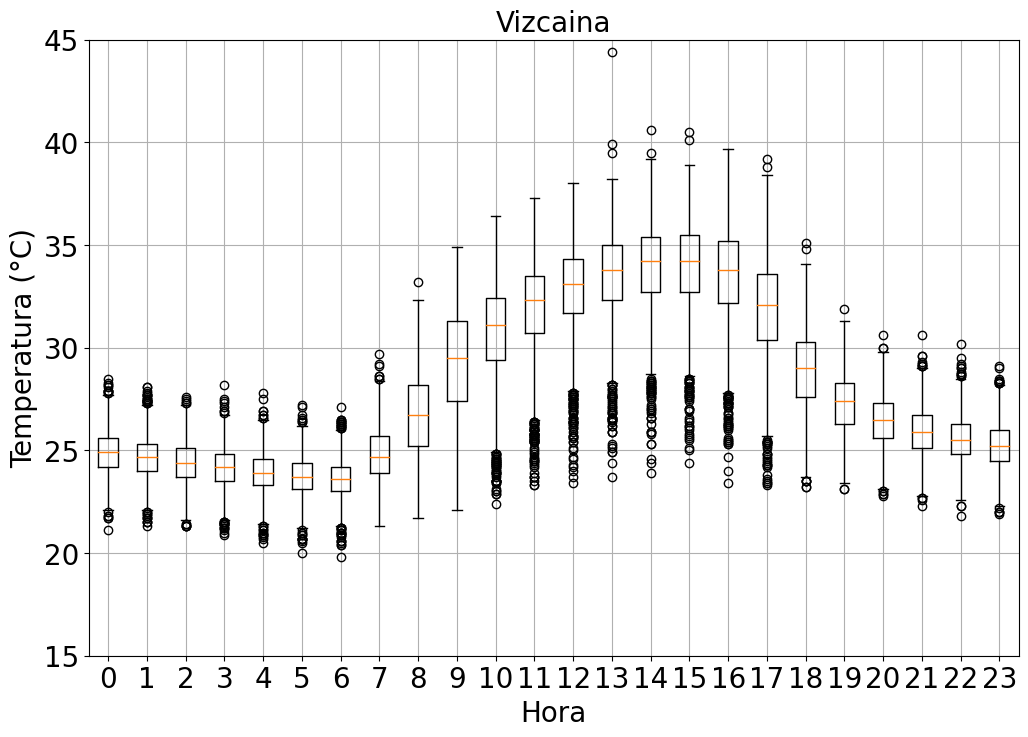

In [9]:
plot_caja_bigote(
    df=df,
    columna_x="HORA",
    columna_y="TEMP",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Hora",
    rotulo_y="Temperatura (°C)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_temp_caja_bigote_palanquero_horario",
    path_para_salvar=PATH_FINAL_FIGURAS_CLIMATOLOGIA
)

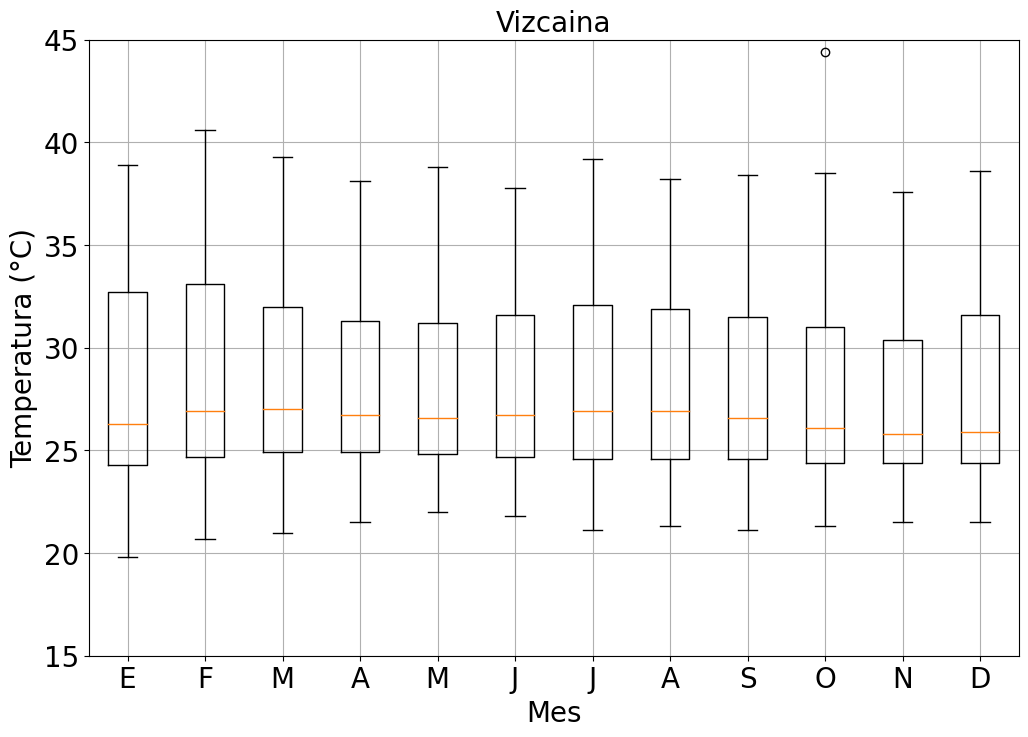

In [10]:
plot_caja_bigote(
    df=df,
    columna_x="MES",
    columna_y="TEMP",
    titulo=NOMBRE_ESTACION.capitalize(),
    rotulo_x="Mes",
    rotulo_y="Temperatura (°C)",
    nombre_estacion=NOMBRE_ESTACION,
    nombre_figura="grafico_temp_caja_bigote_palanquero_mensual",
    path_para_salvar=PATH_FINAL_FIGURAS_CLIMATOLOGIA,
    lista_xtick=['E', 'F',
         'M', 'A',
         'M', 'J',
         'J', 'A',
         'S', 'O',
         'N', 'D']
)

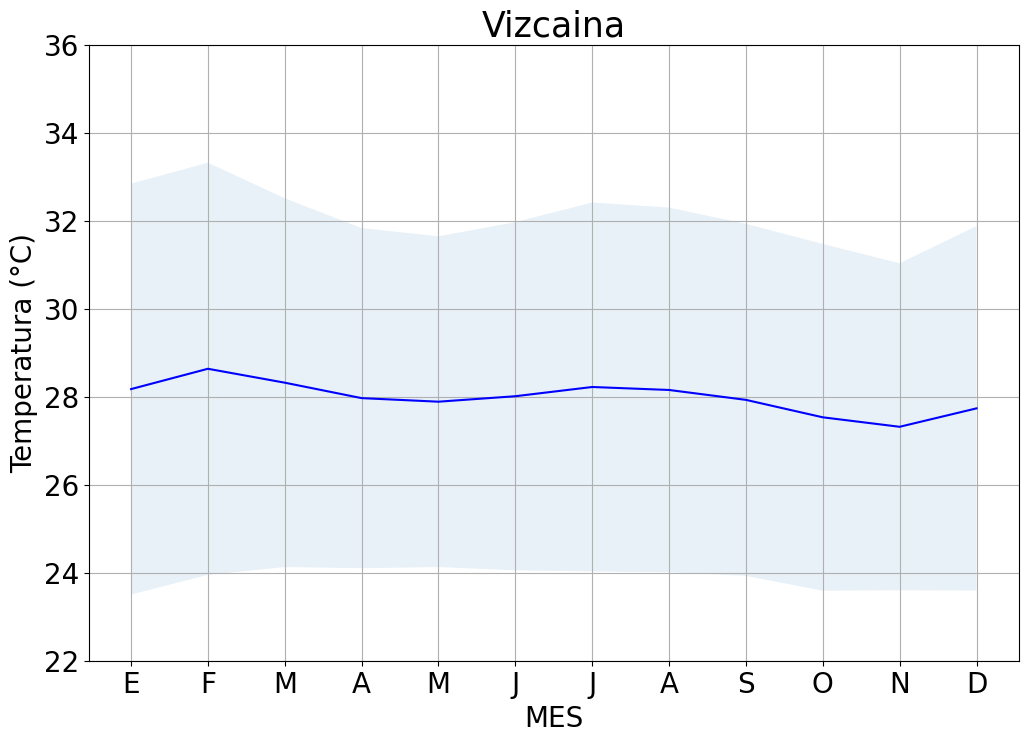

In [11]:
#Start every matrix

#Fill the matrix of the no raining season
dfmes = df.groupby('MES', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
dfmes['mean'] = dfmes[(VARIABLE, 'mean')]
dfmes['std'] = dfmes[(VARIABLE, 'std')]
dfmes = dfmes[['MES', 'mean', 'std']]

def plot_per_month(df, titulo, name_to_save):

  plt.figure(figsize = (12,8))
  df['MES'] = df['MES'].astype(int)

  # plt.xticks()
  plt.plot(df['MES'], df['mean'], color = 'b')
  plt.fill_between(df['MES'], df['mean'] + df['std'], df['mean'] - df['std'], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.grid()
  plt.xlabel("MES", fontsize= 20)
  plt.ylabel(NOMBRE_EJE_Y, fontsize= 20)
  plt.title(titulo, fontsize= 25)

  Meses = ['E', 'F',
         'M', 'A',
         'M', 'J',
         'J', 'A',
         'S', 'O',
         'N', 'D']

  plt.xticks(range(1, 13, 1), labels = Meses, fontsize= 20)
  plt.yticks(np.arange(22, 38, 2),fontsize= 20)
  plt.savefig(PATH_FINAL_FIGURAS_CLIMATOLOGIA + f'{name_to_save}', format='png', bbox_inches = 'tight' )

plot_per_month(dfmes, f'{NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_por_meses.png')

<ipython-input-7-971ac4629e29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HORA'] = df['HORA'].astype(int)


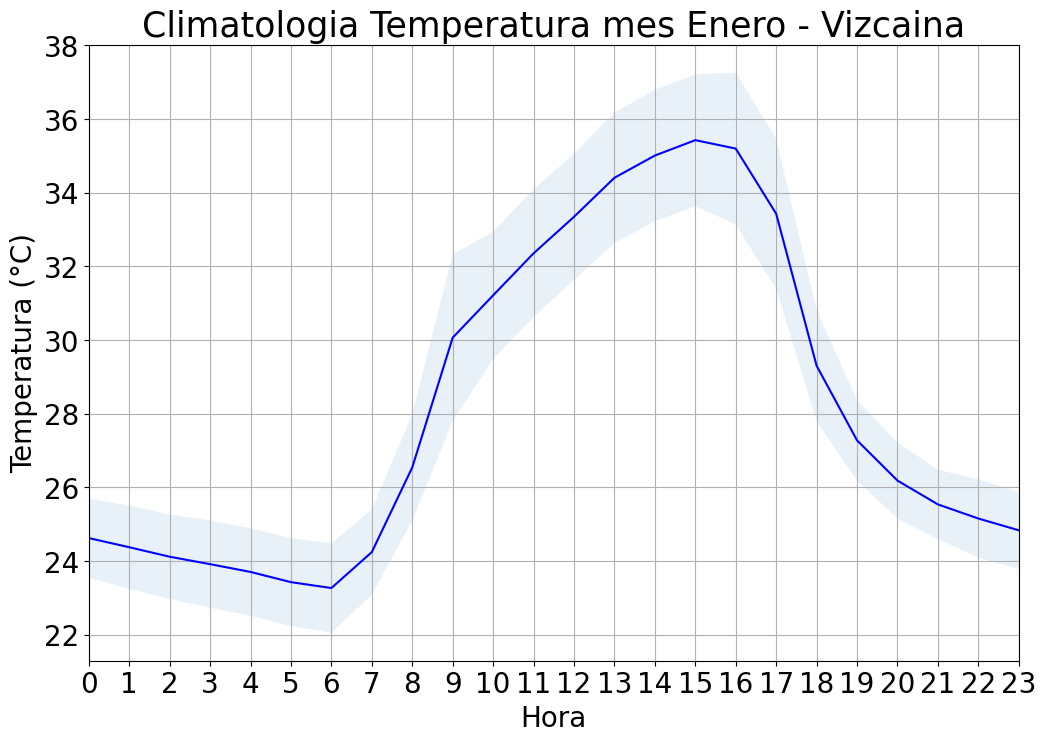

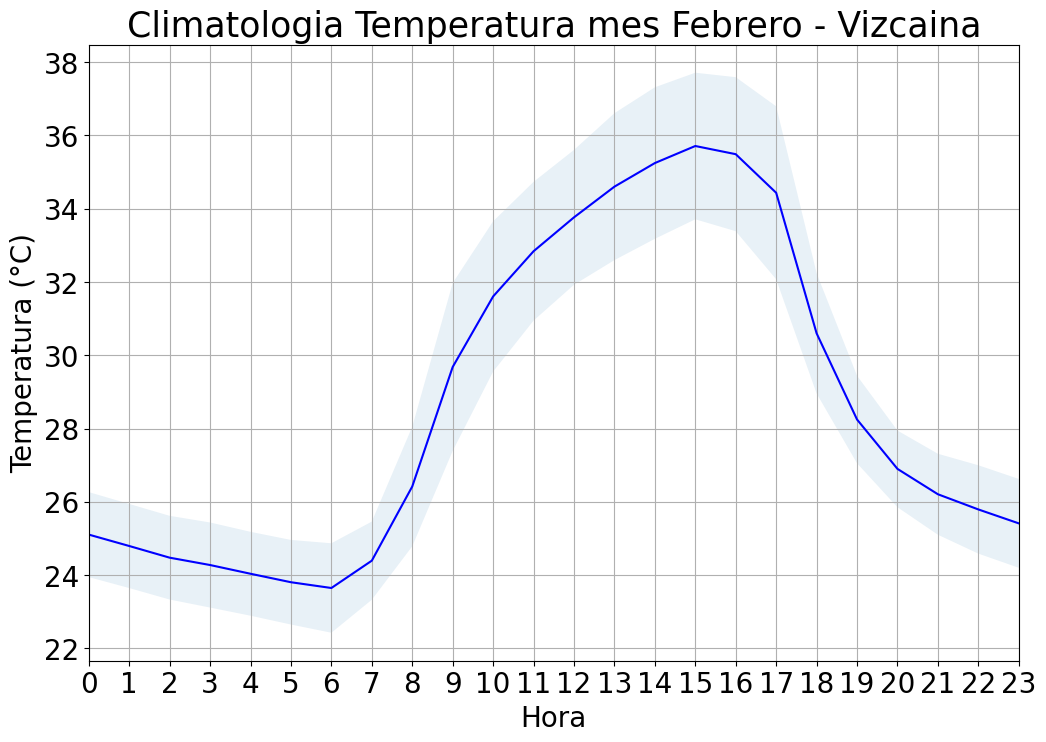

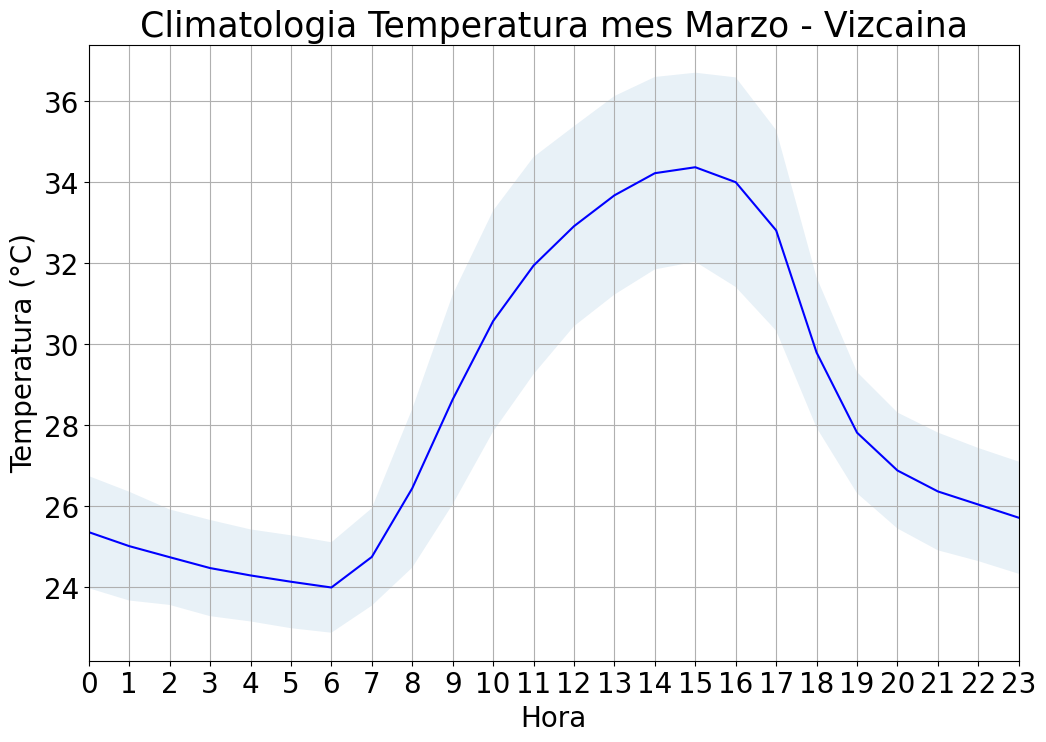

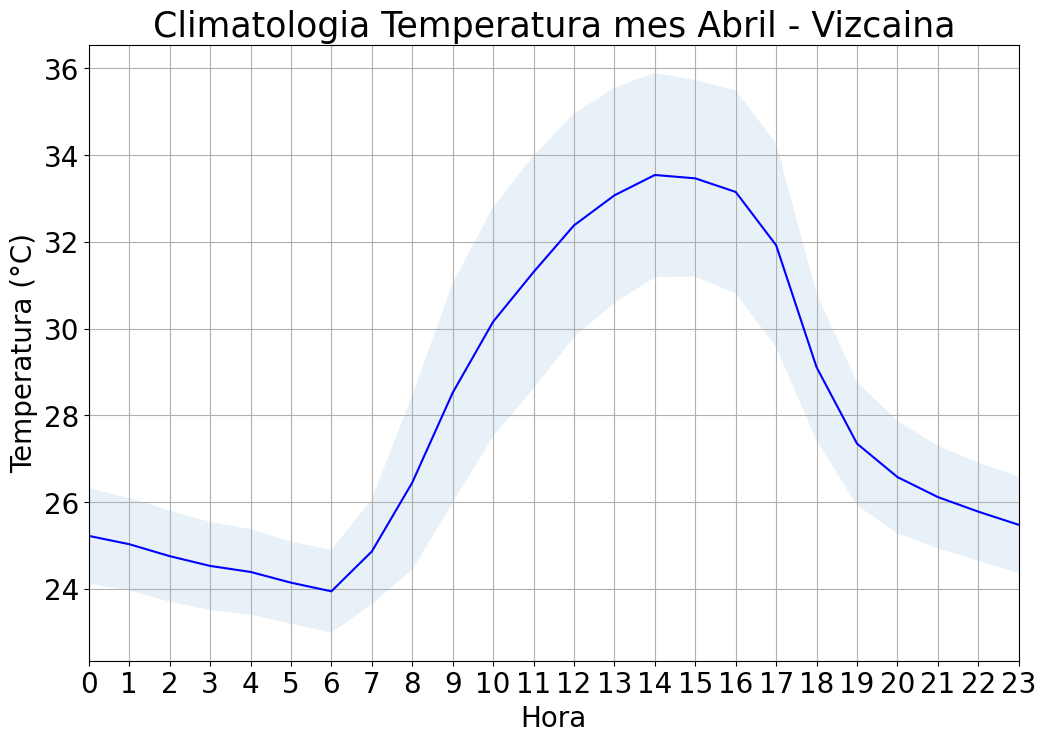

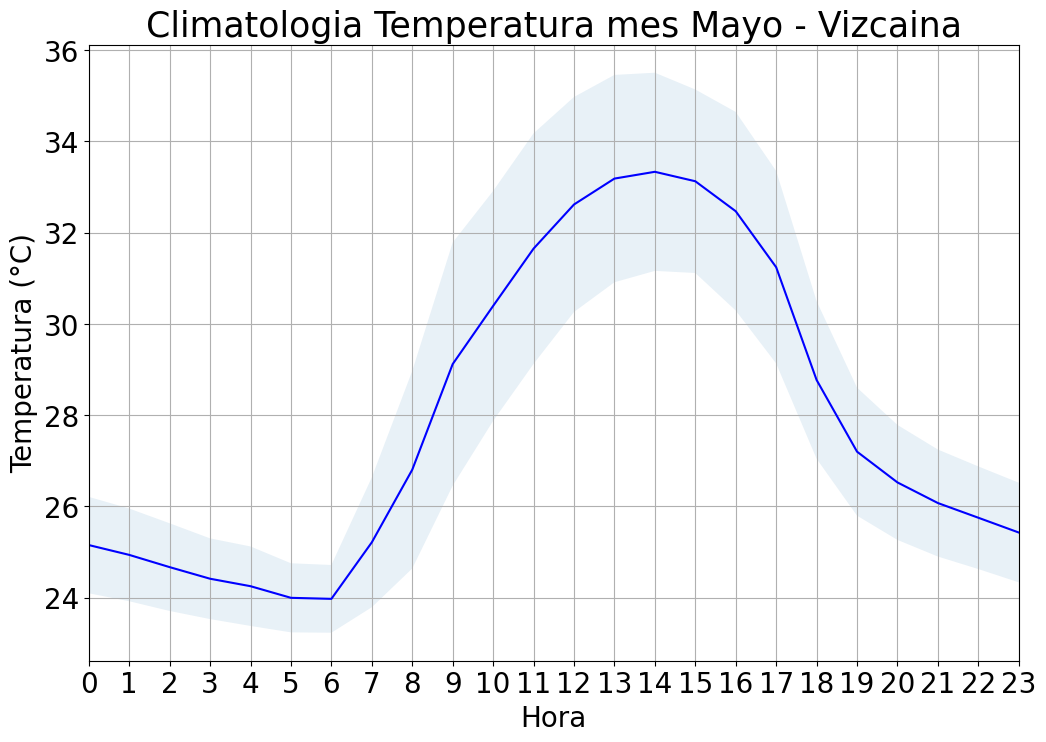

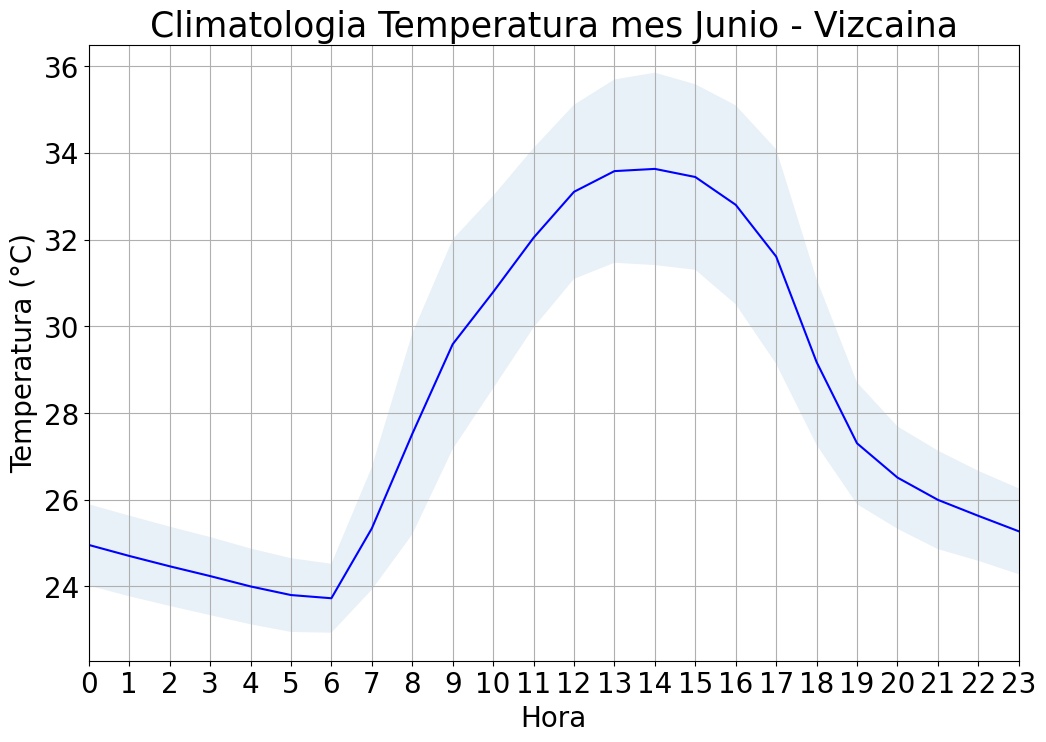

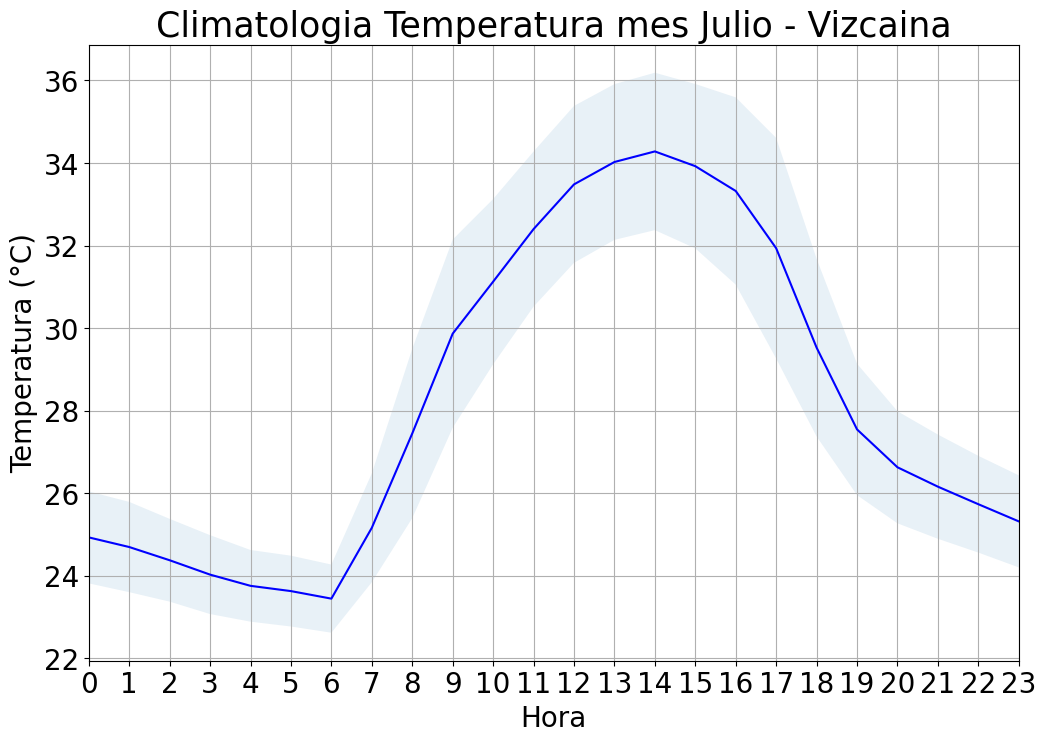

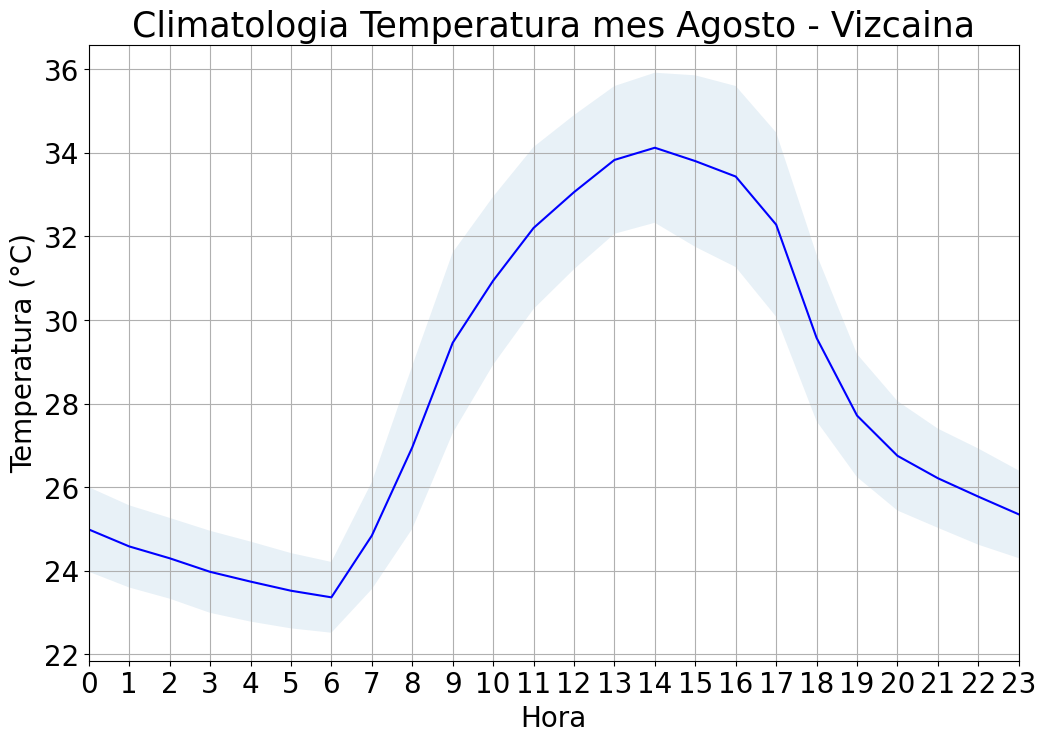

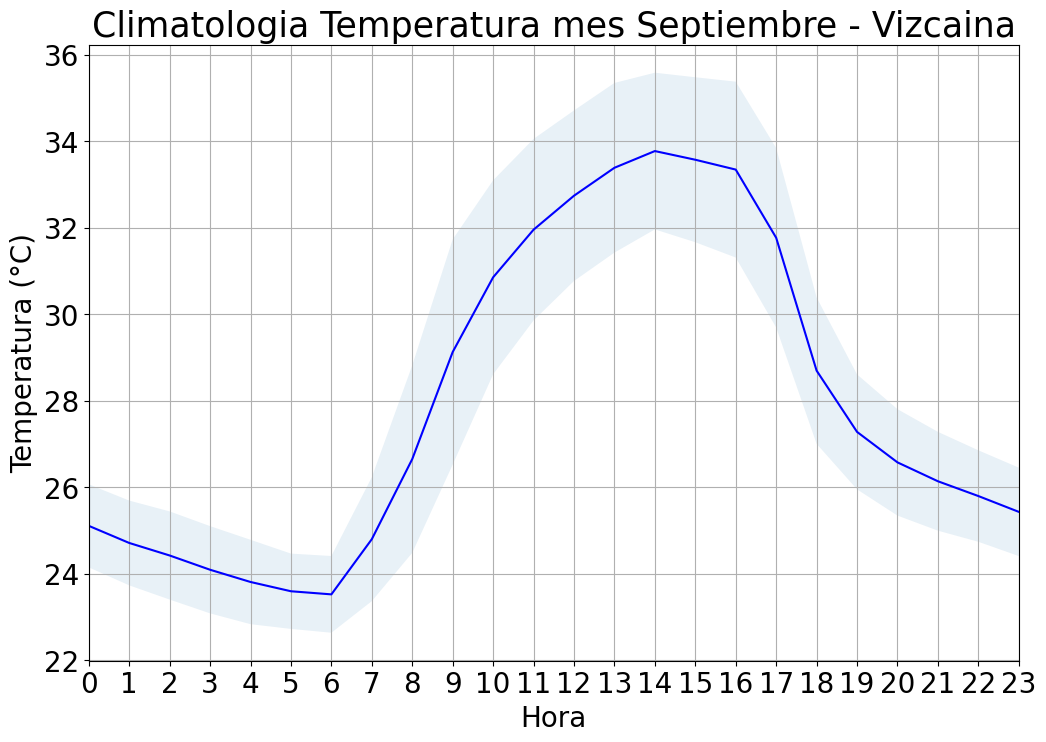

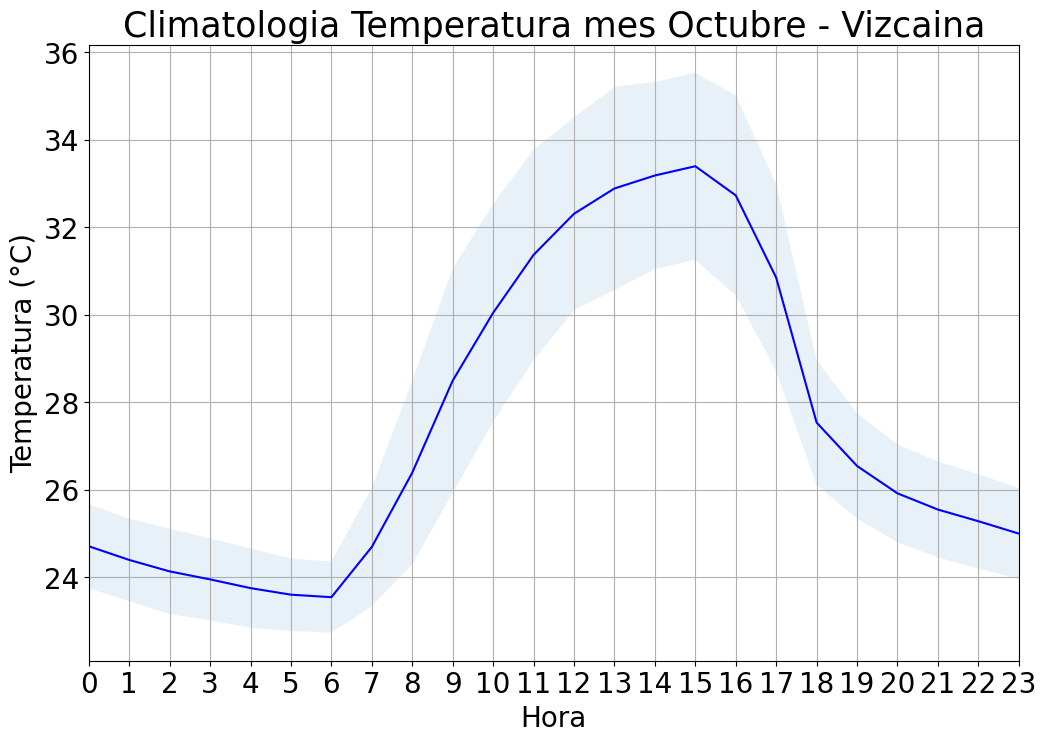

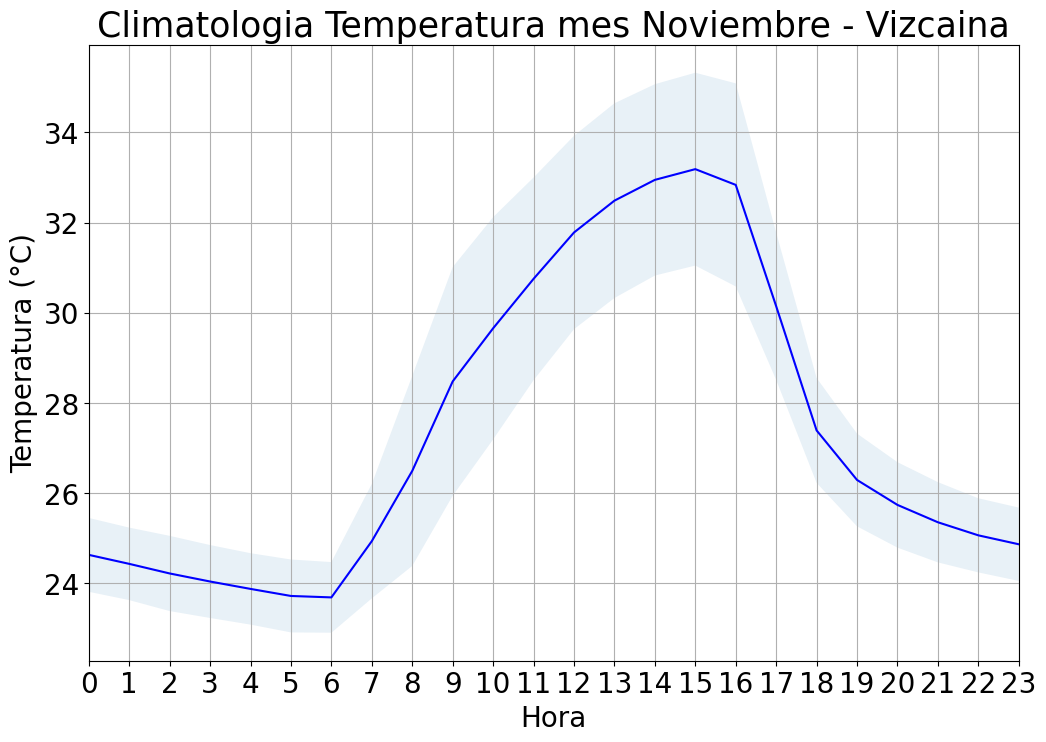

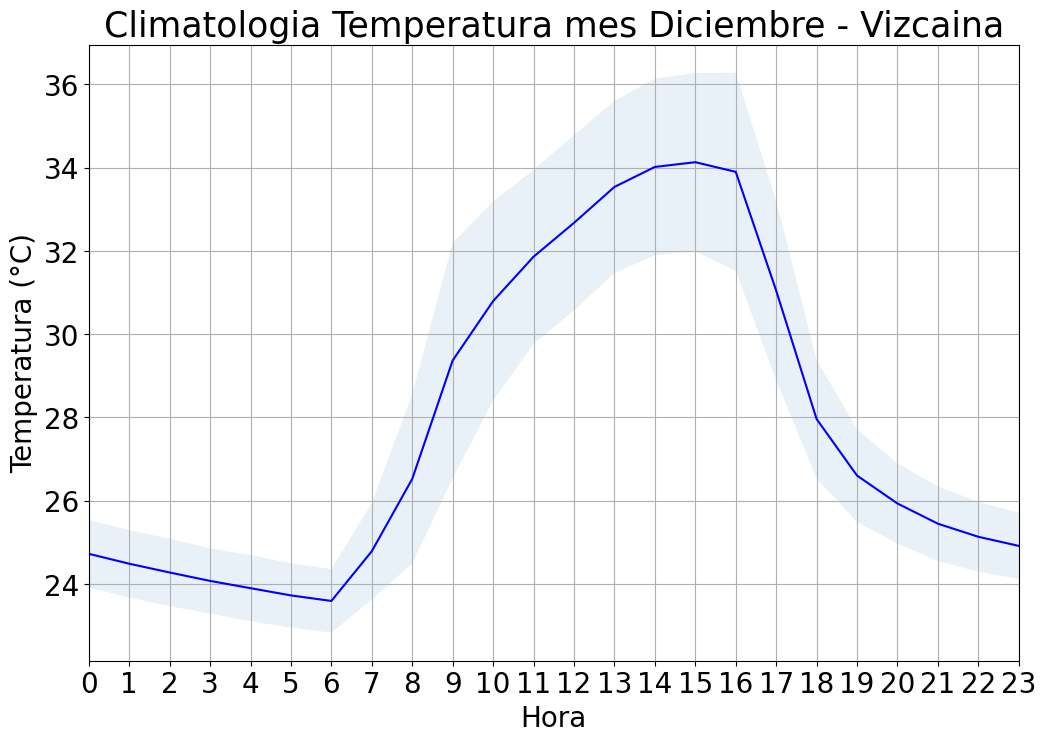

In [12]:
meses = [str(i).zfill(2) for i in range(1, 13)]
meses_str = ['Enero', 'Febrero',
         'Marzo', 'Abril',
         'Mayo', 'Junio',
         'Julio', 'Agosto',
         'Septiembre', 'Octubre',
         'Noviembre', 'Diciembre']


for mes, mes_str in zip(meses, meses_str):
  #Merge the dataframe, so that it will be only one for every season
  dfmes = df[df['MES'].str.contains(mes)]   # DF con los datos de meses con lluvia
  total = dfmes.groupby('HORA', group_keys=False).agg({VARIABLE : ['mean', 'std']}).reset_index(level=0)
  total['mean'] = total[(VARIABLE, 'mean')]
  total['std'] = total[(VARIABLE, 'std')]
  total = total[['HORA', 'mean', 'std']]

  plot_per_hour(total, f'Climatologia {VARIABLE_STR.capitalize()} mes {mes_str} - {NOMBRE_ESTACION.capitalize()}', f'climatologia_{VARIABLE.lower()}_{NOMBRE_ESTACION}_mes_{mes}.png')